# pre-process MaveDB

Sequencing data was processed using Enrich v0.2 and custom scripts. The fitness score $\zeta_i$ for FACS data is described in Kowalsky et al. 2015 and as follows. $\epsilon_i$ is the enrichment ratio of variant $i$, $\epsilon_{wt}$ is the wild-type enrichment ratio, $\sigma$ is the standard deviation of the population and $\phi$ is the percentage of cells collected in the gating population.

$$\zeta_i = \log_2 (e) \sqrt{2} \sigma^{\prime} [erf ^{-1} (1 - \phi 2^{(\epsilon_{wt} + 1)} - erf ^{-1} (1 - \phi 2^{(\epsilon_{i} + 1)}]$$

The fitness score is listed as the score, and the raw $\log_2$ ratios are also included.


* a: Clostridium thermocellum, 1OHZ
* b: Clostridium cellulolyticum, 2VN5

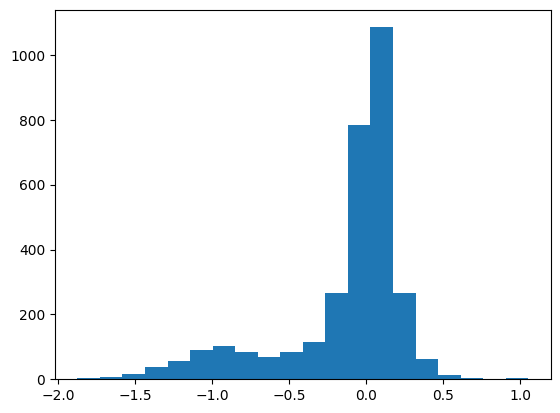

In [1]:
import pandas as pd
import re

df_a = pd.read_csv("./datasets/mavedb/urn mavedb 00000077-a-2_scores.csv")
score = df_a["score"]

import matplotlib.pyplot as plt

plt.hist(score, bins=20)
plt.show()

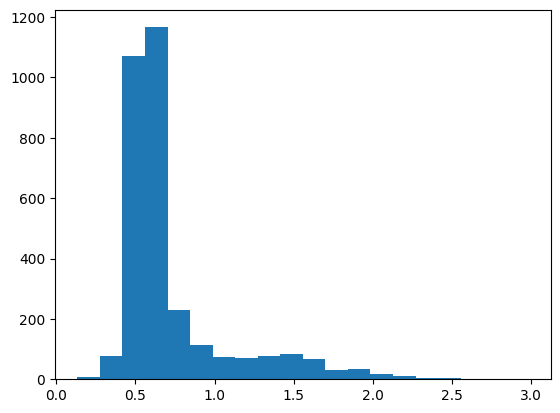

In [20]:

R = float(8.314/4184)
T = 300

ddg =  R * T * (-1/2 + 3/(pow(2, score+1)))

plt.hist(ddg, bins=20)
plt.show()

### clean PDBs

In [2]:
from Bio.PDB import PDBParser, PDBIO, PPBuilder
from Bio.PDB import Structure, Model, Chain, Residue, Atom

original_pdb_path = "./datasets/mavedb/PDBs/"
cleaned_pdb_path = "./datasets/mavedb/cleaned_PDBs/"
pdb_name_list = ["1ohz", "2vn5"]

for pdb_name in pdb_name_list:
    pdb_filepath = f"{original_pdb_path}/{pdb_name}.pdb"

    parser = PDBParser(QUIET=True)
    structure = parser.get_structure(pdb_name, pdb_filepath)
    new_structure = Structure.Structure(pdb_name)

    model = structure[0]
    new_model = Model.Model(model.id)

    for chain in model:
        print(chain)
        new_chain = Chain.Chain(chain.id)

        chain = [res for res in chain.get_residues() if res.id[0] == ' ']  # exclude HOH...
        for residue in chain:
            # print(residue)
            if set(['N', 'CA', 'C', 'O']).issubset(set(residue.child_dict.keys())):
                new_chain.add(residue)
            else:
                if not (residue.id[1] == 1 or residue.id[1] == len(chain)):
                    print(f"WARNING: delete in the middle {residue.full_id} of total len {len(chain)}")

        if len(new_chain) > 0:
            new_model.add(new_chain)
    if len(new_model) > 0:
        new_structure.add(new_model)

    io = PDBIO()
    io.set_structure(new_structure)
    io.save(f"{cleaned_pdb_path}/{pdb_name.upper()}.pdb")


<Chain id=A>
<Chain id=B>
<Chain id=A>
<Chain id=B>


### clean csv

In [3]:
import pandas as pd

df_a = pd.read_csv("./datasets/mavedb/urn mavedb 00000077-a-2_scores.csv")
df_b = pd.read_csv("./datasets/mavedb/urn mavedb 00000077-b-2_scores.csv")



In [4]:
# get protein's available slice
from Bio.PDB import PDBParser, PDBIO, PPBuilder
from Bio.PDB import Structure, Model, Chain, Residue, Atom

import re
def str2int(str):
    return int(re.findall(r'\d+', str)[0])
    
cleaned_pdb_path = "./datasets/mavedb/cleaned_PDBs/"
pdb2df = {"1OHZ": df_a, "2VN5": df_b}

for pdb_name in pdb2df:
    pdb_filepath = f"{cleaned_pdb_path}/{pdb_name}.pdb"

    parser = PDBParser(QUIET=True)
    structure = parser.get_structure(pdb_name, pdb_filepath)
    model = structure[0]
    chain = model['A']
    slice = [res.id[1] for res in chain.get_residues()]
    print(slice)

    drop_list = []
    for idx in range(len(pdb2df[pdb_name])):
        row = pdb2df[pdb_name].iloc[idx]
        mut = row["hgvs_pro"]
        # print(f"{idx}: {mut}")

        if mut == "p.=":
            drop_list.append(idx)
            continue
        pos = str2int(mut)
        if pos not in slice:
            drop_list.append(idx)
            
    pdb2df[pdb_name].drop(drop_list, inplace=True)
    print(len(pdb2df[pdb_name]))

[5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144]
2747
[11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 10

In [5]:
# three2one and drop Ter
three_to_one = {'ALA': 'A', 'CYS': 'C', 'ASP': 'D', 'GLU': 'E', 'PHE': 'F', 'GLY': 'G', 'HIS': 'H', 
                'ILE': 'I', 'LYS': 'K', 'LEU': 'L', 'MET': 'M', 'ASN': 'N', 'PRO': 'P', 'GLN': 'Q', 
                'ARG': 'R', 'SER': 'S', 'THR': 'T', 'VAL': 'V', 'TRP': 'W', 'TYR': 'Y'}

def mutation_three2one(mutation_three):
    if "Ter" in mutation_three:
        return None
    mutation_three = mutation_three[2:]
    wt = mutation_three[0:3].upper()
    mut = mutation_three[-3:].upper()
    mutation_one = three_to_one[wt] + 'A' + mutation_three[3:-3] + three_to_one[mut]

    return mutation_one


In [6]:

df_a["mutation"] = df_a["hgvs_pro"].apply(mutation_three2one)
df_a.dropna(subset=["mutation"], inplace=True)

df_a["pdb"] = "1OHZ"
df_a

,accession,hgvs_nt,hgvs_splice,hgvs_pro,score,score_err,log2_ratio,log2_ratio_err,mutation,pdb
0,urn:mavedb:00000077-a-2#1683,NaN,NaN,p.Thr90Tyr,0.268293,0.002756,0.907146,0.024403,TA90Y,1OHZ
1,urn:mavedb:00000077-a-2#1691,NaN,NaN,p.Gly89Asp,-0.845925,0.016225,-3.444642,0.383943,GA89D,1OHZ
2,urn:mavedb:00000077-a-2#1684,NaN,NaN,p.Thr90Trp,0.223610,0.018987,0.772588,0.176329,TA90W,1OHZ
3,urn:mavedb:00000077-a-2#1685,NaN,NaN,p.Thr90Phe,0.270579,0.004217,0.913944,0.037246,TA90F,1OHZ
5,urn:mavedb:00000077-a-2#1687,NaN,NaN,p.Gly89Arg,-0.613270,0.001423,-2.360385,0.028277,GA89R,1OHZ
...,...,...,...,...,...,...,...,...,...,...
3134,urn:mavedb:00000077-a-2#1663,NaN,NaN,p.Gly91Tyr,0.061075,0.004649,0.255797,0.051013,GA91Y,1OHZ
3135,urn:mavedb:00000077-a-2#1664,NaN,NaN,p.Gly91Trp,-0.679713,NaN,-2.660371,NaN,GA91W,1OHZ
3136,urn:mavedb:00000077-a-2#1665,NaN,NaN,p.Gly91Phe,-0.052447,0.005684,-0.130904,0.069653,GA91F,1OHZ
3138,urn:mavedb:00000077-a-2#1667,NaN,NaN,p.Thr90Arg,0.282191,0.001123,0.948346,0.009793,TA90R,1OHZ


In [7]:
df_b["mutation"] = df_b["hgvs_pro"].apply(mutation_three2one)
df_b.dropna(subset=["mutation"], inplace=True)

df_b["pdb"] = "2VN5"
df_b

,accession,hgvs_nt,hgvs_splice,hgvs_pro,score,score_err,log2_ratio,log2_ratio_err,mutation,pdb
0,urn:mavedb:00000077-b-2#5,NaN,NaN,p.Pro152Asn,-0.2034,0.030048,-1.823702,0.541011,PA152N,2VN5
1,urn:mavedb:00000077-b-2#6,NaN,NaN,p.Pro152Thr,0.6532,0.001545,0.843493,0.013990,PA152T,2VN5
2,urn:mavedb:00000077-b-2#7,NaN,NaN,p.Pro152Ser,-0.0050,0.000807,-1.099224,0.012523,PA152S,2VN5
3,urn:mavedb:00000077-b-2#8,NaN,NaN,p.Pro152Gly,1.2556,0.003210,2.043741,0.017049,PA152G,2VN5
4,urn:mavedb:00000077-b-2#9,NaN,NaN,p.Pro152Ala,0.5726,0.001541,0.642383,0.014964,PA152A,2VN5
...,...,...,...,...,...,...,...,...,...,...
2877,urn:mavedb:00000077-b-2#2882,NaN,NaN,p.Gly25Glu,0.0533,0.002075,0.306412,0.022427,GA25E,2VN5
2920,urn:mavedb:00000077-b-2#1,NaN,NaN,p.Pro152Arg,1.0672,0.001302,1.723530,0.008182,PA152R,2VN5
2921,urn:mavedb:00000077-b-2#2,NaN,NaN,p.Pro152His,0.4213,0.002764,0.237698,0.030492,PA152H,2VN5
2922,urn:mavedb:00000077-b-2#3,NaN,NaN,p.Pro152Asp,-0.5971,NaN,-3.459432,1.573849,PA152D,2VN5


In [8]:
info_a = df_a[["pdb", "mutation", "score"]]
info_b = df_b[["pdb", "mutation", "score"]]

# compute ddg
R = float(8.314/4184)
T = 300

info_a["ddg"] = R * T * (-1/2 + 3/(pow(2, info_a["score"]+1)))
info_b["ddg"] = R * T * (-1/2 + 3/(pow(2, info_b["score"]+1)))

info = pd.concat([info_a, info_b], ignore_index=True)
info

/tmp/ipykernel_3135512/2298134710.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  info_a["ddg"] = R * T * (-1/2 + 3/(pow(2, info_a["score"]+1)))
/tmp/ipykernel_3135512/2298134710.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  info_b["ddg"] = R * T * (-1/2 + 3/(pow(2, info_b["score"]+1)))


,pdb,mutation,score,ddg
0,1OHZ,TA90Y,0.268293,0.444385
1,1OHZ,GA89D,-0.845925,1.309172
2,1OHZ,TA90W,0.223610,0.467740
3,1OHZ,TA90F,0.270579,0.443210
4,1OHZ,GA89R,-0.613270,1.069802
...,...,...,...,...
5225,2VN5,GA25E,0.053300,0.563695
5226,2VN5,PA152R,1.067200,0.128684
5227,2VN5,PA152H,0.421300,0.369675
5228,2VN5,PA152D,-0.597100,1.054556


### EvoEF2 generate mutant .pdb

In [18]:
import os
from tqdm import tqdm
import subprocess

EvoEF2_toolpath = "./tools/EvoEF2/EvoEF2"
cleaned_pdb_path = "./datasets/mavedb/cleaned_PDBs/"
mut_pdb_path = "./datasets/mavedb/mut_PDBs/"
os.makedirs(mut_pdb_path, exist_ok=True)

for i in tqdm(range(len(info))):
    wt = info.loc[i, 'pdb']
    mut_site = info.loc[i, 'mutation']
    name = wt.split('_')[0]
    mut_name = f"{wt}_{mut_site}"
    # print(f"{name} -> {mut_name}")

    with open(f"{mut_pdb_path}/{mut_name}.txt", 'w') as f:
        f.write(mut_site + ';')
    
    cmd = f"{EvoEF2_toolpath} --command=BuildMutant \
                --pdb={cleaned_pdb_path}/{name}.pdb --mutant_file={mut_pdb_path}/{mut_name}.txt && \
            mv {name}_Model_0001.pdb {mut_pdb_path}/{mut_name}.pdb && \
            rm {mut_pdb_path}/{mut_name}.txt"
    # print(cmd)
    subprocess.run(cmd, shell=True, stdout=subprocess.DEVNULL)

# besides buffer overflow, 1KBH would also fail because the illegal original .pdb and its' mutation sites.

100%|██████████| 5230/5230 [39:07<00:00,  2.23it/s]


### save processed dataset

In [9]:

import torch

info.to_csv("./data/mavedb/info.csv",index=False)
torch.save(info, "./data/mavedb/dataset.pt")


# prepare feature

In [10]:
import os

import numpy as np
import torch

from tqdm import tqdm

### load processed dataset

In [11]:
info = torch.load("./data/mavedb/dataset.pt")
info

,pdb,mutation,score,ddg
0,1OHZ,TA90Y,0.268293,0.444385
1,1OHZ,GA89D,-0.845925,1.309172
2,1OHZ,TA90W,0.223610,0.467740
3,1OHZ,TA90F,0.270579,0.443210
4,1OHZ,GA89R,-0.613270,1.069802
...,...,...,...,...
5225,2VN5,GA25E,0.053300,0.563695
5226,2VN5,PA152R,1.067200,0.128684
5227,2VN5,PA152H,0.421300,0.369675
5228,2VN5,PA152D,-0.597100,1.054556


### collect .pdb files

In [12]:
import subprocess

data_pdb_path = "./data/mavedb/pdb/"
os.makedirs(data_pdb_path, exist_ok=True)

os.system(f"cp ./datasets/mavedb/cleaned_PDBs/*.pdb {data_pdb_path}")
os.system(f"cp ./datasets/mavedb/mut_PDBs/*.pdb {data_pdb_path}")

print(f"Total .pdb file: {subprocess.check_output(f'ls {data_pdb_path} | wc -w', shell=True)}")


Total .pdb file: b'5232\n'


In [14]:
wt_name_list = [f"{pdb.split('_')[0]}" for pdb in set(info['pdb'])]
mut_name_list = [f"{mut}" for mut in set(info['pdb'] +'_'+ info['mutation'])]

### extract sequence & coordinate from .pdb file

In [15]:
from utils import *

from Bio.PDB import PDBParser

data_seq_path = "./data/mavedb/seq/"
data_coord_path = "./data/mavedb/coord/"
os.makedirs(data_seq_path, exist_ok=True)
os.makedirs(data_coord_path, exist_ok=True)

for name in tqdm(wt_name_list + mut_name_list):
    
    pdb_filepath = f"{data_pdb_path}/{name}.pdb"
    parser = PDBParser(QUIET=True)
    struct = parser.get_structure(name, pdb_filepath)
    res_list = get_clean_res_list(struct.get_residues(), verbose=False, ensure_ca_exist=True)
    # ensure all res contains N, CA, C and O
    res_list = [res for res in res_list if (('N' in res) and ('CA' in res) and ('C' in res) and ('O' in res))]

    # extract sequence
    seq = "".join([three_to_one.get(res.resname) for res in res_list])

    # extract coordinate
    coord = []
    for res in res_list:
        res_coord = []
        R_group = []
        for atom in res:
            if atom.get_name() in ['N', 'CA', 'C', 'O']:
                res_coord.append(atom.get_coord())
            else:
                R_group.append(atom.get_coord())

        if len(R_group) == 0:
            R_group.append(res['CA'].get_coord())
        R_group = np.array(R_group).mean(axis=0)
        res_coord.append(R_group)
        coord.append(res_coord)
    coord = np.array(coord)  # convert list directly to tensor would be rather slow, suggest use ndarray as transition
    coord = torch.tensor(coord, dtype=torch.float32)

    # save to file
    seq_to_file = f"{data_seq_path}/{name}.txt"
    coord_to_file = f"{data_coord_path}/{name}.pt"
    with open(seq_to_file, "w") as seq_file:
        seq_file.write(seq)
    torch.save(coord, coord_to_file)


  0%|          | 1/5232 [00:00<11:53,  7.33it/s]

100%|██████████| 5232/5232 [02:41<00:00, 32.45it/s]


### extract ProtTrans feature from sequence

In [16]:
import gc
from tqdm import tqdm
import torch
from transformers import T5Tokenizer, T5EncoderModel

In [17]:
data_seq_path = "./data/mavedb/seq/"
ProtTrans_toolpath = "./tools/Prot-T5-XL-U50/"
gpu = '3'

# Load the vocabulary and ProtT5-XL-UniRef50 Model
tokenizer = T5Tokenizer.from_pretrained(ProtTrans_toolpath, do_lower_case=False)
model = T5EncoderModel.from_pretrained(ProtTrans_toolpath)
gc.collect()

# Load the model into the GPU if avilabile and switch to inference mode
device = torch.device('cuda:' + gpu if torch.cuda.is_available() and gpu else 'cpu')
model = model.to(device)
model = model.eval()


Some weights of the model checkpoint at ./tools/Prot-T5-XL-U50/ were not used when initializing T5EncoderModel: ['decoder.block.9.layer.0.SelfAttention.k.weight', 'decoder.block.23.layer.1.EncDecAttention.k.weight', 'decoder.block.8.layer.0.SelfAttention.k.weight', 'decoder.block.14.layer.0.SelfAttention.k.weight', 'decoder.block.10.layer.2.DenseReluDense.wi.weight', 'decoder.block.23.layer.0.SelfAttention.o.weight', 'decoder.block.4.layer.0.SelfAttention.v.weight', 'decoder.block.14.layer.0.SelfAttention.v.weight', 'decoder.block.18.layer.0.layer_norm.weight', 'decoder.block.21.layer.1.EncDecAttention.o.weight', 'decoder.block.9.layer.2.layer_norm.weight', 'decoder.block.9.layer.0.SelfAttention.v.weight', 'decoder.block.12.layer.1.EncDecAttention.v.weight', 'decoder.block.12.layer.2.layer_norm.weight', 'decoder.block.21.layer.0.layer_norm.weight', 'decoder.block.2.layer.1.EncDecAttention.o.weight', 'decoder.block.15.layer.1.EncDecAttention.o.weight', 'decoder.block.0.layer.2.layer_nor

In [18]:
data_ProtTrans_raw_path = "./data/mavedb/ProtTrans_raw/"
os.makedirs(data_ProtTrans_raw_path, exist_ok=True)

for name in tqdm(wt_name_list + mut_name_list):
    with open(f"{data_seq_path}/{name}.txt") as seq_file:
        seq = seq_file.readline()
    batch_name_list = [name]
    batch_seq_list = [" ".join(list(seq))]
    # print(len(seq))
    # print(batch_name_list)
    # print(batch_seq_list)

    # Tokenize, encode sequences and load it into the GPU if possibile
    ids = tokenizer.batch_encode_plus(batch_seq_list, add_special_tokens=True, padding=True)
    input_ids = torch.tensor(ids['input_ids']).to(device)
    attention_mask = torch.tensor(ids['attention_mask']).to(device)

    # Extracting sequences' features and load it into the CPU if needed
    with torch.no_grad():
        embedding = model(input_ids=input_ids,attention_mask=attention_mask)
    embedding = embedding.last_hidden_state.cpu()

    # Remove padding (\<pad>) and special tokens (\</s>) that is added by ProtT5-XL-UniRef50 model
    for seq_num in range(len(embedding)):
        seq_len = (attention_mask[seq_num] == 1).sum()
        seq_emb = embedding[seq_num][:seq_len-1]
        # print(f"truncate padding: {embedding[seq_num].shape} -> {seq_emb.shape}")
        ProtTrans_to_file = f"{data_ProtTrans_raw_path}/{batch_name_list[seq_num]}.npy"
        np.save(ProtTrans_to_file, seq_emb)


100%|██████████| 5232/5232 [03:47<00:00, 22.96it/s]


#### normalize raw ProtTrans

In [19]:
Max_protrans = []
Min_protrans = []
for name in tqdm(wt_name_list + mut_name_list):
    raw_protrans = np.load(f"{data_ProtTrans_raw_path}/{name}.npy")
    Max_protrans.append(np.max(raw_protrans, axis = 0))
    Min_protrans.append(np.min(raw_protrans, axis = 0))

Min_protrans = np.min(np.array(Min_protrans), axis = 0)
Max_protrans = np.max(np.array(Max_protrans), axis = 0)
print(Min_protrans)
print(Max_protrans)

np.save("./data/mavedb/Max_ProtTrans_repr.npy", Max_protrans)
np.save("./data/mavedb/Min_ProtTrans_repr.npy", Min_protrans)

100%|██████████| 5232/5232 [00:02<00:00, 1863.37it/s]


[-0.68037933 -0.54340184 -0.8650721  ... -0.55334574 -0.6190129
 -0.77261645]
[0.7412149  0.64162946 0.71753764 ... 0.8070278  0.7498722  0.87101203]


In [20]:
Max_protrans = np.load("./data/mavedb/Max_ProtTrans_repr.npy")
Min_protrans = np.load("./data/mavedb/Min_ProtTrans_repr.npy")

data_ProtTrans_path = "./data/mavedb/ProtTrans/"
os.makedirs(data_ProtTrans_path, exist_ok=True)

for name in tqdm(wt_name_list + mut_name_list):
    raw_protrans = np.load(f"{data_ProtTrans_raw_path}/{name}.npy")
    protrans = (raw_protrans - Min_protrans) / (Max_protrans - Min_protrans)
    ProtTrans_to_file = f"{data_ProtTrans_path}/{name}.pt"
    torch.save(torch.tensor(protrans, dtype = torch.float32), ProtTrans_to_file)


100%|██████████| 5232/5232 [00:09<00:00, 524.84it/s]


### extract DSSP feature from .pdb file

#### correct format of mut.pdb: col of Occupancy(55 - 60) should be "{:.2f}"

In [21]:
data_pdb_path = "./data/mavedb/pdb/"

for name in tqdm(mut_name_list):
    pdb_filepath = f"{data_pdb_path}/{name}.pdb"

    with open(pdb_filepath, "r") as f:
        lines = f.readlines()

    for i in range(len(lines)):
        if lines[i].split()[0] == "REMARK":
            continue
        lines[i] = lines[i][:57] + '.00' + lines[i][60:]

    with open(pdb_filepath, "w") as f:
        f.writelines(lines)


100%|██████████| 5230/5230 [01:01<00:00, 84.69it/s] 


In [22]:
from utils import *

data_pdb_path = "./data/mavedb/pdb/"
data_seq_path = "./data/mavedb/seq/"
dssp_toolpath = "./tools/mkdssp"

data_DSSP_path = "./data/mavedb/DSSP"
os.makedirs(data_DSSP_path, exist_ok=True)

for name in tqdm(wt_name_list + mut_name_list):
    pdb_filepath = f"{data_pdb_path}/{name}.pdb"
    with open(f"{data_seq_path}/{name}.txt") as seq_file:
        seq = seq_file.readline()

    DSSP_to_file = f"{data_DSSP_path}/{name}.dssp"
    dssp_cmd = f"{dssp_toolpath} -i {pdb_filepath} -o {DSSP_to_file}"
    os.system(dssp_cmd)

    try:
        dssp_seq, dssp_matrix = process_dssp(DSSP_to_file)
        # dssp_seq: likely equal to original sequence
        # dssp_matrix (list<ndarray>): list of (1, 9) vector, length of dssp_seq
        if dssp_seq != seq:
            dssp_matrix = match_dssp(dssp_seq, dssp_matrix, seq)
        
        DSSP_to_file = f"{data_DSSP_path}/{name}.pt"
        torch.save(torch.tensor(np.array(dssp_matrix), dtype = torch.float32), DSSP_to_file)
        # shape(AA_len, 9)
        # os.system("rm {DSSP_to_file}"")
    except:
        print(f"Wrong entry prompt: $ {dssp_cmd}")
        continue


100%|██████████| 5232/5232 [05:18<00:00, 16.44it/s]


# validate wt & mut feature match

In [24]:
from utils import match_wt2mut
# 1Y3B @282
# 1Y4A @275
# 2FTL @223

match_wt2mut("1OHZ", "1OHZ_AA36E", "./data/mavedb/")
match_wt2mut("2VN5", "2VN5_GA146Y", "./data/mavedb/")


verify sequence whether match: 
wt: 196 - mut: 196
32: A -> E
verify coordinate whether match: 
wt: torch.Size([196, 5, 3]) - mut: torch.Size([196, 5, 3])
verify ProtTrans feature whether match: 
wt: torch.Size([196, 1024]) - mut: torch.Size([196, 1024])
verify DSSP feature whether match: 
wt: torch.Size([196, 9]) - mut: torch.Size([196, 9])
verify sequence whether match: 
wt: 198 - mut: 198
136: G -> Y
verify coordinate whether match: 
wt: torch.Size([198, 5, 3]) - mut: torch.Size([198, 5, 3])
verify ProtTrans feature whether match: 
wt: torch.Size([198, 1024]) - mut: torch.Size([198, 1024])
verify DSSP feature whether match: 
wt: torch.Size([198, 9]) - mut: torch.Size([198, 9])


# prepare dataset

In [25]:
import random
import numpy as np
import torch

info = torch.load("./data/mavedb/dataset.pt")
info


,pdb,mutation,score,ddg
0,1OHZ,TA90Y,0.268293,0.444385
1,1OHZ,GA89D,-0.845925,1.309172
2,1OHZ,TA90W,0.223610,0.467740
3,1OHZ,TA90F,0.270579,0.443210
4,1OHZ,GA89R,-0.613270,1.069802
...,...,...,...,...
5225,2VN5,GA25E,0.053300,0.563695
5226,2VN5,PA152R,1.067200,0.128684
5227,2VN5,PA152H,0.421300,0.369675
5228,2VN5,PA152D,-0.597100,1.054556


In [26]:
# change Dataframe column name
info.rename(columns={'pdb': 'wt_name'}, inplace=True)
info.rename(columns={'mutation': 'mut_name'}, inplace=True)
info["mut_name"] = info["wt_name"] + "_" + info["mut_name"]

info.drop(columns=['score'], inplace=True)
torch.save(info, "./data/mavedb/dataset_processed.pt")
info

,wt_name,mut_name,ddg
0,1OHZ,1OHZ_TA90Y,0.444385
1,1OHZ,1OHZ_GA89D,1.309172
2,1OHZ,1OHZ_TA90W,0.467740
3,1OHZ,1OHZ_TA90F,0.443210
4,1OHZ,1OHZ_GA89R,1.069802
...,...,...,...
5225,2VN5,2VN5_GA25E,0.563695
5226,2VN5,2VN5_PA152R,0.128684
5227,2VN5,2VN5_PA152H,0.369675
5228,2VN5,2VN5_PA152D,1.054556
